# Ejercicio SVM datos Eurocopa 2012
A partir del archivo Euro_2012_stats_TEAM, se pide:

1. Obtener la matriz de correlación. ¿Qué columnas están mejor correlacionadas?

2. ¿Existe algún tipo de relación entre la precisión de disparo a puerta (Shooting Accuracy) con respecto a los goles? Muestra en una gráfica (pintando la línea en la distribución de ambas variables) y usando Regresión Lineal, Regresión no Lineal con polinomio y SVR la relación entre ambos

3. Si tratamos la columna Goals como una columna categórica y usando logistic regression, SVM y Random forest, ¿cuántos goles marcaría un equipo que tiene...? (por cada algoritmo):

    - % de goles por disparo: 40%
    - Total shots (inc. Blocked): 102
    - Corners Taken: 5
    - Passes: 82
    - Dribbles: 23

## 1. Importa las librerias necesarias

In [177]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

%matplotlib inline

## 2. Carga los datos

In [178]:
df = pd.read_csv('./data/Euro_2012_stats_TEAM.csv')
df.head()

,Team,Goals,Shots on target,Shots off target,Shooting Accuracy,% Goals-to-shots,Total shots (inc. Blocked),Hit Woodwork,Penalty goals,Penalties not scored,...,Saves made,Saves-to-shots ratio,Fouls Won,Fouls Conceded,Offsides,Yellow Cards,Red Cards,Subs on,Subs off,Players Used
0,Croatia,4,13,12,51.9%,16.0%,32,0,0,0,...,13,81.3%,41,62,2,9,0,9,9,16
1,Czech Republic,4,13,18,41.9%,12.9%,39,0,0,0,...,9,60.1%,53,73,8,7,0,11,11,19
2,Denmark,4,10,10,50.0%,20.0%,27,1,0,0,...,10,66.7%,25,38,8,4,0,7,7,15
3,England,5,11,18,50.0%,17.2%,40,0,0,0,...,22,88.1%,43,45,6,5,0,11,11,16
4,France,3,22,24,37.9%,6.5%,65,1,0,0,...,6,54.6%,36,51,5,6,0,11,11,19


## 3. Obtener la matriz de correlación con TODAS las variables. ¿Hay algunas columnas que estén muy correlacionadas?

In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Team                        16 non-null     object 
 1   Goals                       16 non-null     int64  
 2   Shots on target             16 non-null     int64  
 3   Shots off target            16 non-null     int64  
 4   Shooting Accuracy           16 non-null     object 
 5   % Goals-to-shots            16 non-null     object 
 6   Total shots (inc. Blocked)  16 non-null     int64  
 7   Hit Woodwork                16 non-null     int64  
 8   Penalty goals               16 non-null     int64  
 9   Penalties not scored        16 non-null     int64  
 10  Headed goals                16 non-null     int64  
 11  Passes                      16 non-null     int64  
 12  Passes completed            16 non-null     int64  
 13  Passing Accuracy            16 non-nu

In [180]:
#Hay que averiguar al naturaleza de los datos
df[df.dtypes[df.dtypes == 'object'].index]

,Team,Shooting Accuracy,% Goals-to-shots,Passing Accuracy,Saves-to-shots ratio
0,Croatia,51.9%,16.0%,76.9%,81.3%
1,Czech Republic,41.9%,12.9%,78.1%,60.1%
2,Denmark,50.0%,20.0%,83.3%,66.7%
3,England,50.0%,17.2%,80.6%,88.1%
4,France,37.9%,6.5%,87.2%,54.6%
5,Germany,47.8%,15.6%,87.4%,62.6%
6,Greece,30.7%,19.2%,76.7%,65.1%
7,Italy,43.0%,7.5%,83.9%,74.1%
8,Netherlands,25.0%,4.1%,88.7%,70.6%
9,Poland,39.4%,5.2%,80.4%,66.7%


In [181]:
# Para poder seguir trabajando con este dataset, lo primero es convertir esta columnas a numéricas
df.Team.unique()

array(['Croatia', 'Czech Republic', 'Denmark', 'England', 'France',
       'Germany', 'Greece', 'Italy', 'Netherlands', 'Poland', 'Portugal',
       'Republic of Ireland', 'Russia', 'Spain', 'Sweden', 'Ukraine'],
      dtype=object)

In [182]:
#Codificamos el string de los paises
label_encoder = LabelEncoder()
df['Team'] = label_encoder.fit_transform(df['Team'])
df.loc[:,['Team']]

,Team
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


Los valores de las columnas Shooting Accuracy, % Goals-to-shots, Passing Accuracy y	Saves-to-shots ratio, son *object* ya que sus valores contiene el elemento '%' (string)

In [183]:
df.loc[2, 'Shooting Accuracy']

'50.0%'

In [184]:
col_object = df[df.dtypes[df.dtypes == 'object'].index].columns
col_object

Index(['Shooting Accuracy', '% Goals-to-shots', 'Passing Accuracy',
       'Saves-to-shots ratio'],
      dtype='object')

In [185]:
#Transformamos columnas 'object' en numérico
for col in col_object:
    df[col] = df[col].apply(lambda x: float(x[:-1]))

In [186]:
df.head()

,Team,Goals,Shots on target,Shots off target,Shooting Accuracy,% Goals-to-shots,Total shots (inc. Blocked),Hit Woodwork,Penalty goals,Penalties not scored,...,Saves made,Saves-to-shots ratio,Fouls Won,Fouls Conceded,Offsides,Yellow Cards,Red Cards,Subs on,Subs off,Players Used
0,0,4,13,12,51.9,16.0,32,0,0,0,...,13,81.3,41,62,2,9,0,9,9,16
1,1,4,13,18,41.9,12.9,39,0,0,0,...,9,60.1,53,73,8,7,0,11,11,19
2,2,4,10,10,50.0,20.0,27,1,0,0,...,10,66.7,25,38,8,4,0,7,7,15
3,3,5,11,18,50.0,17.2,40,0,0,0,...,22,88.1,43,45,6,5,0,11,11,16
4,4,3,22,24,37.9,6.5,65,1,0,0,...,6,54.6,36,51,5,6,0,11,11,19


In [187]:
df.loc[2, 'Shooting Accuracy']

50.0

In [188]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Team                        16 non-null     int32  
 1   Goals                       16 non-null     int64  
 2   Shots on target             16 non-null     int64  
 3   Shots off target            16 non-null     int64  
 4   Shooting Accuracy           16 non-null     float64
 5   % Goals-to-shots            16 non-null     float64
 6   Total shots (inc. Blocked)  16 non-null     int64  
 7   Hit Woodwork                16 non-null     int64  
 8   Penalty goals               16 non-null     int64  
 9   Penalties not scored        16 non-null     int64  
 10  Headed goals                16 non-null     int64  
 11  Passes                      16 non-null     int64  
 12  Passes completed            16 non-null     int64  
 13  Passing Accuracy            16 non-nu

In [35]:
df_corr = df.corr()
df_corr

,Team,Goals,Shots on target,Shots off target,Shooting Accuracy,% Goals-to-shots,Total shots (inc. Blocked),Hit Woodwork,Penalty goals,Penalties not scored,...,Saves made,Saves-to-shots ratio,Fouls Won,Fouls Conceded,Offsides,Yellow Cards,Red Cards,Subs on,Subs off,Players Used
Team,1.000000,0.058209,0.092627,0.370392,-0.417231,-0.401858,0.218381,0.243157,0.052105,-0.084017,...,-0.027556,0.178606,0.187289,-0.038378,0.159678,0.105063,1.215784e-01,0.019790,0.019790,0.082503
Goals,0.058209,1.000000,0.804193,0.403821,0.521210,0.533239,0.650109,0.200512,0.730437,0.023094,...,0.143912,0.394424,0.663876,0.483833,0.703043,0.337709,-3.580574e-01,0.727830,0.727830,0.136067
Shots on target,0.092627,0.804193,1.000000,0.611185,0.504487,0.049623,0.886090,0.212932,0.478610,-0.229945,...,0.085059,0.218915,0.765949,0.658353,0.696263,0.544307,-3.340500e-01,0.821342,0.821342,0.249516
Shots off target,0.370392,0.403821,0.611185,1.000000,-0.269946,-0.389095,0.887032,0.581655,0.126783,-0.173221,...,0.086157,0.187128,0.615058,0.434815,0.344626,0.534186,-3.377661e-01,0.544974,0.544974,0.045973
Shooting Accuracy,-0.417231,0.521210,0.504487,-0.269946,1.000000,0.548827,0.125994,-0.198917,0.234263,-0.223483,...,0.179562,0.220664,0.235577,0.406282,0.382686,0.163668,-1.883518e-01,0.377589,0.377589,-0.022610
% Goals-to-shots,-0.401858,0.533239,0.049623,-0.389095,0.548827,1.000000,-0.195113,-0.087481,0.480954,0.370202,...,0.121014,0.238564,0.034561,0.014626,0.255441,-0.071731,-1.669397e-01,0.130146,0.130146,-0.022179
Total shots (inc. Blocked),0.218381,0.650109,0.886090,0.887032,0.125994,-0.195113,1.000000,0.400121,0.299397,-0.234668,...,0.148269,0.252407,0.766215,0.623288,0.589635,0.622268,-3.604662e-01,0.763336,0.763336,0.157812
Hit Woodwork,0.243157,0.200512,0.212932,0.581655,-0.198917,-0.087481,0.400121,1.000000,-0.076923,-0.041345,...,-0.230524,-0.200695,0.141180,0.303987,0.113657,0.319708,-2.820513e-01,0.204511,0.204511,-0.189466
Penalty goals,0.052105,0.730437,0.478610,0.126783,0.234263,0.480954,0.299397,-0.076923,1.000000,0.537484,...,0.058761,0.135145,0.528185,0.114404,0.627220,0.085467,1.794872e-01,0.531727,0.531727,0.351866
Penalties not scored,-0.084017,0.023094,-0.229945,-0.173221,-0.223483,0.370202,-0.234668,-0.041345,0.537484,1.000000,...,0.051019,-0.149787,0.163643,-0.107169,0.210417,0.127603,5.374838e-01,0.084796,0.084796,0.480079


"\nax = sns.heatmap(\n    corr_matrix, \n    vmin=-1, vmax=1, center=0,\n    cmap=sns.diverging_palette(20, 220, n=200),\n    square=True,\n)\nax.set_xticklabels(\n    ax.get_xticklabels(),\n    rotation=45,\n    horizontalalignment='right'\n);\n"

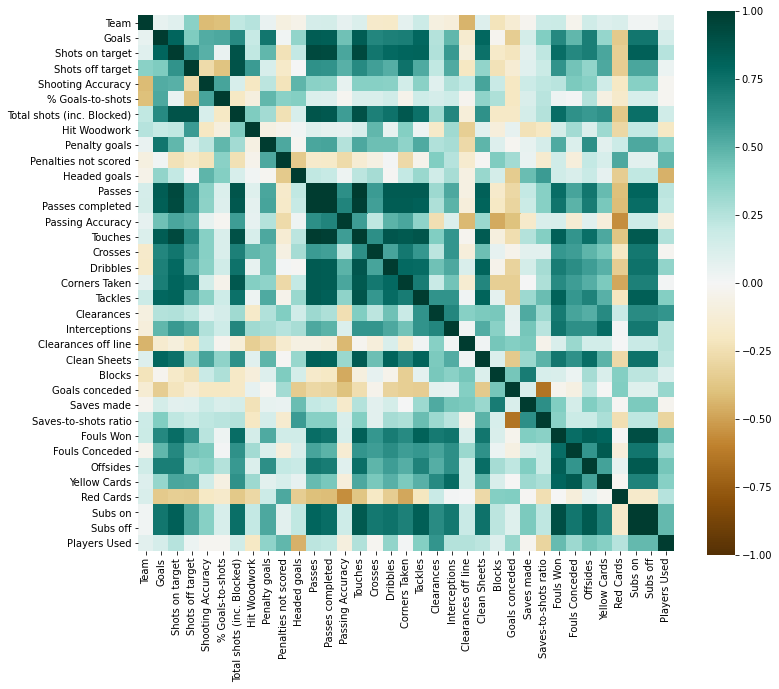

In [58]:
plt.subplots(figsize=(12,10))
sns.heatmap(df_corr,
            vmin= -1,
            vmax= 1,
            center= 0,
            cmap= "BrBG",
            square= True)
"""
ax = sns.heatmap(
    corr_matrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
"""

In [65]:
corr_abs = np.abs(df_corr)
correlation_df = corr_abs[(corr_abs > 0.90) & (corr_abs < 1.0)]
[column for column in correlation_df.notna().columns if any(correlation_df.notna()[column] == True)]

['Shots on target',
 'Passes',
 'Passes completed',
 'Touches',
 'Fouls Won',
 'Subs on',
 'Subs off']

## 4. ¿Existe algún tipo de relación entre la precisión de disparo a puerta (Shooting Accuracy) con respecto a los goles? Muestra en una gráfica (pintando la línea en la distribución de ambas variables) y usando Regresión Lineal, Regresión no Lineal con polinomio y SVR la relación entre ambos

In [76]:
print(f"La correlación entre 'Shooting Accuracy' y 'Goals es de {round(df_corr.loc['Shooting Accuracy','Goals'],3)*100} %")

La correlación entre 'Shooting Accuracy' y 'Goals es de 52.1 %


''

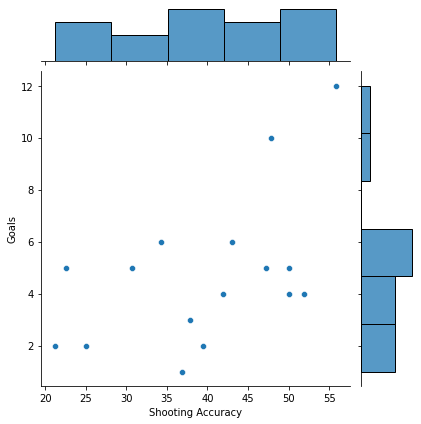

In [78]:
sns.jointplot(x=df['Shooting Accuracy'], y=df['Goals'])
;

(20.0, 58.0)

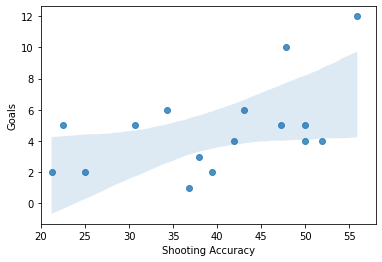

In [82]:
sns.regplot(x='Shooting Accuracy',y='Goals', data=df)
plt.xlim(20,58)

In [137]:
dictionary_model_reg = {"poly_model": Pipeline([("polynomial_features", PolynomialFeatures(10)),
                                                ("linear_regression", LinearRegression())]),
                        "linear_model": LinearRegression(),
                        "support_model": SVR()
                       }


X = np.array(df["Shooting Accuracy"]).reshape(-1,1)
y = df.Goals

In [147]:
def train_model_reg(dict_model, X, y):
    dict_scores = {"model":[], "score":[]}
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)
    print(X_train.shape, y_train.shape)
    
    for k,v in dict_model.items():         
        v.fit(X_train, y_train)
        y_pred = v.predict(X_train)

        score = r2_score(y_train, y_pred)
   
        lista_val = [k, score]
        for i,e in enumerate(["model", "score"]):
            dict_scores[e].append(lista_val[i])

        X_train_to_show, y_train_to_show = zip(*sorted(zip(X_train, y_train)))
        print(X_train_to_show)
        print(y_train_to_show)
        plt.scatter(X_train_to_show, y_train_to_show, color='lightblue')
        X_train_to_show, y_pred = zip(*sorted(zip(X_train, y_pred)))
        plt.plot(X_train_to_show, y_pred, color='blue')
        plt.title(f"{k}")
        plt.show()
        
    return pd.DataFrame(dict_scores)

(12, 1) (12,)
(array([21.2]), array([25.]), array([30.7]), array([36.8]), array([37.9]), array([39.4]), array([41.9]), array([43.]), array([47.2]), array([50.]), array([51.9]), array([55.9]))
(2, 2, 5, 1, 3, 2, 4, 6, 5, 5, 4, 12)


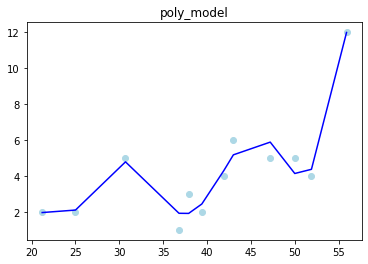

(array([21.2]), array([25.]), array([30.7]), array([36.8]), array([37.9]), array([39.4]), array([41.9]), array([43.]), array([47.2]), array([50.]), array([51.9]), array([55.9]))
(2, 2, 5, 1, 3, 2, 4, 6, 5, 5, 4, 12)


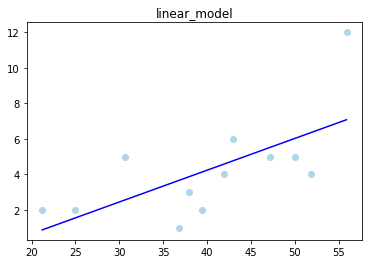

(array([21.2]), array([25.]), array([30.7]), array([36.8]), array([37.9]), array([39.4]), array([41.9]), array([43.]), array([47.2]), array([50.]), array([51.9]), array([55.9]))
(2, 2, 5, 1, 3, 2, 4, 6, 5, 5, 4, 12)


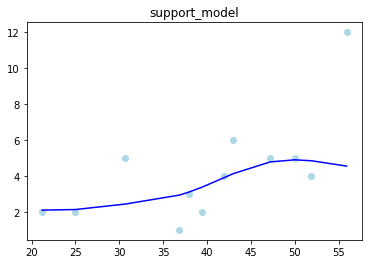

,model,score
0,poly_model,0.949026
1,linear_model,0.428854
2,support_model,0.219897


In [148]:
train_model_reg(dict_model=dictionary_model_reg, X=X, y=y)

## 5. Si tratamos la columna Goals como una columna categórica y usando logistic regression, SVM y Random forest, ¿cuántos goles marcaría un equipo que tiene...? (por cada algoritmo):

    - % de goles por disparo: 40%
    - Total shots (inc. Blocked): 102
    - Corners Taken: 5
    - Passes: 82
    - Dribbles: 23

In [210]:
new_data = np.array([[40.0,102,5,82,23]])
new_data

array([[ 40., 102.,   5.,  82.,  23.]])

In [195]:
df.columns

Index(['Team', 'Goals', 'Shots on target', 'Shots off target',
       'Shooting Accuracy', '% Goals-to-shots', 'Total shots (inc. Blocked)',
       'Hit Woodwork', 'Penalty goals', 'Penalties not scored', 'Headed goals',
       'Passes', 'Passes completed', 'Passing Accuracy', 'Touches', 'Crosses',
       'Dribbles', 'Corners Taken', 'Tackles', 'Clearances', 'Interceptions',
       'Clearances off line', 'Clean Sheets', 'Blocks', 'Goals conceded',
       'Saves made', 'Saves-to-shots ratio', 'Fouls Won', 'Fouls Conceded',
       'Offsides', 'Yellow Cards', 'Red Cards', 'Subs on', 'Subs off',
       'Players Used'],
      dtype='object')

In [197]:
df[['% Goals-to-shots','Total shots (inc. Blocked)','Corners Taken','Passes','Dribbles']].head()

,% Goals-to-shots,Total shots (inc. Blocked),Corners Taken,Passes,Dribbles
0,16.0,32,14,1076,42
1,12.9,39,21,1565,68
2,20.0,27,16,1298,32
3,17.2,40,16,1488,60
4,6.5,65,28,2066,76


In [190]:
list(df['Goals'].unique())

[4, 5, 3, 10, 6, 2, 1, 12]

In [191]:
categories = list(df['Goals'].unique())
categories

[4, 5, 3, 10, 6, 2, 1, 12]

In [192]:
#Definir las categorías en la columna 'Goals'
cat_type = pd.CategoricalDtype(categories= categories, ordered=True)
cat_type

CategoricalDtype(categories=[4, 5, 3, 10, 6, 2, 1, 12], ordered=True)

In [193]:
df['Goals'] = df['Goals'].astype(cat_type)

In [194]:
df.Goals

0      4
1      4
2      4
3      5
4      3
5     10
6      5
7      6
8      2
9      2
10     6
11     1
12     5
13    12
14     5
15     2
Name: Goals, dtype: category
Categories (8, int64): [4 < 5 < 3 < 10 < 6 < 2 < 1 < 12]

In [204]:
dictionary_model_classifier = {"random_forest_model": RandomForestClassifier(),
                        "logistic_regression_model": LogisticRegression(),
                        "support_model": SVC()
                       }


X = df[['% Goals-to-shots','Total shots (inc. Blocked)','Corners Taken','Passes','Dribbles']]
y = df.Goals

In [205]:
print('Shape_X ',X.shape, '\nShape_y ',y.shape)

Shape_X  (16, 5) 
Shape_y  (16,)


In [207]:
def train_model_cat(dict_model, X, y, X_new):
    dict_scores = {"model":[], "prediction":[]}
    
    #X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)
    #print(X_train.shape, y_train.shape)
    
    for key,value in dict_model.items():         
        value.fit(X, y)
        y_pred = value.predict(X_new)
        print(y_pred)

        

In [208]:
lista_val = [k, y_pred[]]
        for i,e in enumerate(["model", "score"]):
            dict_scores[e].append(lista_val[i])

SyntaxError: invalid syntax (<ipython-input-208-8acc4a5ed161>, line 1)

In [206]:
train_model_cat(dictionary_model_classifier, X, y, X_new=np.array([[40.0,]])

[ 4  4  4  5  3 10  5  6  2  2  6  1  5 12  5  2]
[ 5  4  4  5  3 10  5  6  2  6  6  5  5 12  5 10]
[5 5 5 5 5 6 5 6 5 5 5 5 5 6 5 5]
